In [1]:
from LoopDataConverter import LoopConverter, InputData, SurveyName, Datatype, NtgsConfig
from osgeo import gdal, osr
import os 
from map2loop import Project#, logging
import map2loop
import tempfile
# logging.set_level('debug')

In [2]:
def create_raster(output_path, bbox, epsg, pixel_size, value=100):
    minx, miny, maxx, maxy = bbox
    cols = int((maxx - minx) / pixel_size)
    rows = int((maxy - miny) / pixel_size)
    driver = gdal.GetDriverByName('GTiff')
    out_raster = driver.Create(output_path, cols, rows, 1, gdal.GDT_Byte)
    out_raster.SetGeoTransform([minx, pixel_size, 0, maxy, 0, -pixel_size])
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    out_raster.SetProjection(srs.ExportToWkt())
    out_band = out_raster.GetRasterBand(1)
    out_band.Fill(value)
    out_band.FlushCache()
    out_raster = None

In [3]:
import geopandas

def get_bounding_box(shapefile_path, zmax=3000, zmin=-3000):
    """
    Returns the bounding box of the given shapefile.
    
    Parameters:
        shapefile_path (str): Path to the shapefile.
    
    Returns:
        dict: Bounding box with minx, miny, maxx, maxy.
    """
    gdf = geopandas.read_file(shapefile_path)
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    bounding_box = {
        "minx": bounds[0],
        "miny": bounds[1],
        "maxx": bounds[2],
        "maxy": bounds[3],
        "base": zmin,
        "top": zmax,
    }
    return bounding_box

bounding_box = get_bounding_box("../test_data/NTGS_data/Henbury/bounding_box.shp")

# xmin, ymax = 194809, 7342124
# xmax, ymin = 269919, 7314400
# zmin, zmax = -3000, 3000
# bounding_box = {
#     "minx": xmin,
#     "miny": ymin,
#     "maxx": xmax,
#     "maxy": ymax,
#     "base": zmin,
#     "top": zmax,
# }
f_path = "/home/rabii/Git_Repos/LoopDataConverter/test_data/NTGS_data/Henbury"
create_raster(
    os.path.join(f_path, "DEM.tif"),
    (bounding_box['minx'], bounding_box['miny'], bounding_box['maxx'], bounding_box['maxy']),
    7854,
    1000,
)
bounding_box

/home/rabii/Git_Repos/m2l_pypi/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


{'minx': np.float64(194915.04765542696),
 'miny': np.float64(7314111.534384862),
 'maxx': np.float64(269996.050907918),
 'maxy': np.float64(7343389.948186358),
 'base': -3000,
 'top': 3000}

In [4]:
input_data = InputData(
    GEOLOGY="../test_data/NTGS_data/Henbury/NT_LithOutcrop_250k_shp.shp", 
    STRUCTURE="../test_data/NTGS_data/Henbury/NT_StructData_250k_shp.shp",
    FAULT="../test_data/NTGS_data/Henbury/NT_Fault_250k_shp.shp",
    FOLD="../test_data/NTGS_data/Henbury/NT_Fold_250k_shp.shp"
)

loop_converter = LoopConverter(survey_name=SurveyName.NTGS,
                               data=input_data)
loop_converter.convert()

In [5]:
path = tempfile.mkdtemp()
loop_converter.save(Datatype.GEOLOGY, os.path.join(path, "geology.shp"), file_extension="shp")
loop_converter.save(Datatype.STRUCTURE, os.path.join(path, "structures.shp"), file_extension="shp")
loop_converter.save(Datatype.FOLD, os.path.join(path, "folds.shp"), file_extension="shp")
loop_converter.save(Datatype.FAULT, os.path.join(path, "faults.shp"), file_extension="shp")

In [6]:
import os
from map2loop.project import Project
from map2loop.m2l_enums import VerboseLevel
from map2loop.m2l_enums import Datatype
from map2loop.sampler import SamplerSpacing, SamplerDecimator
from map2loop.sorter import SorterUseHint, SorterUseNetworkX, SorterAgeBased, SorterAlpha, SorterObservationProjections
from map2loop.thickness_calculator import InterpolatedStructure, StructuralPoint
import time
from datetime import datetime
nowtime=datetime.now().isoformat(timespec='minutes')
model_name=nowtime.replace(":","-").replace("T","-")
loop_project_filename = os.path.join(model_name, "HB_map.loop3d")

t0 = time.time()

ntgs_config = NtgsConfig()
config = ntgs_config.config_map

# Initialise the project with the shapefiles, dtm, config file
# output locations and projection to work in
proj = Project(
    geology_filename = os.path.join(path, "geology.shp"),
    fault_filename = os.path.join(path, "faults.shp"),
    structure_filename = os.path.join(path, "structures.shp"),
    fold_filename= os.path.join(path, "folds.shp"),
    dtm_filename = "../test_data/NTGS_data/Henbury/DEM.tif",
    config_dictionary= config,
    clut_filename = '../test_data/NTGS_data/500kibg_colours.csv',
    clut_file_legacy = True,
    verbose_level = VerboseLevel.ALL,
    tmp_path = model_name,
    working_projection = "EPSG:28353",#"EPSG:4283",
    bounding_box = bounding_box,
    loop_project_filename = loop_project_filename,
    overwrite_loopprojectfile = True
)

# Remove faults less than 5km
proj.set_minimum_fault_length(0.0)

# Set sampling distance for geology and fault maps to 200m
proj.set_sampler(Datatype.GEOLOGY, SamplerSpacing(50.0))
proj.set_sampler(Datatype.FAULT, SamplerSpacing(200.0))

# Set to only take every second orientation observation (0 or 1 means take all observations)
proj.set_sampler(Datatype.STRUCTURE, SamplerDecimator(2))

# Set what text is expected for intrusions (contained within the description field)
# proj.map_data.config.geology_config["intrusive_text"] = "mafic intrusive"

# Set specific layers from the geology map to be ignored (commonly "cover" or "water")
proj.set_ignore_codes(["None", "No_formal_name", "Julie_Formation", "Stokes_Siltstone",])

proj.set_thickness_calculator(InterpolatedStructure())
# Specify which stratigraphic columns sorter to use, other options are
# (SorterAlpha, SorterAgeBased, SorterUseHint, SorterUseNetworkX, SorterMaximiseContacts, SorterObservationProjections)
proj.set_sorter(SorterObservationProjections())

# Or you can run map2loop and pre-specify the stratigraphic column
# column = [
#     # youngest
#     'No_formal_name',
#     'Chandler_Limestone',
#     'Arumbera_Sandstone',
#     'Pertatataka_Formation',
#     'Waldo_Pedlar_Formation',
#     'Aralka_Formation',
#     'Areyonga_Formation',
#     'Bitter_Springs_Formation'
#     # oldest
# ]

full_column = [
    # youngest
    "Brewer_Conglomerate",
    "Hermannsburg_Sandstone",
    "Parke_Siltstone",
    "Mereenie_Sandstone",
    "Carmichael_Sandstone",
    "Stokes_Siltstone",
    "Stairway_Sandstone",
    "Horn_Valley_Siltstone",
    "Pacoota_Sandstone",
    "Goyder_Formation",
    "Jay_Creek_Limestone",
    "Petermann_Sandstone",
    "Deception_Formation",
    "Illara_Sandstone",
    "Tempe_Formation",
    "Chandler_Formation",
    "Arumbera_Sandstone",
    "Namatjira_Formation",
    "Puna_Kura_Kura_Formation",
    "Julie_Formation",
    "Liddle_Formation",
    "Pertatataka_Formation",
    "Froud_Formation",
    "Gloaming_Formation",
    "Quandong_Conglomerate",
    "Breaden_Formation",
    "Pioneer_Sandstone",
    "Aralka_Formation",
    "Areyonga_Formation",
    "Wallara_Formation",
    "Johnnys_Creek_Formation",
    "Loves_Creek_Formation",
    "Gillen_Formation",
    'No_formal_name',
    # oldest
]

column = [
    # 'No_formal_name',
    'Hermannsburg_Sandstone',
    'Parke_Siltstone',
    'Mereenie_Sandstone',
    'Carmichael_Sandstone',
    # 'Stokes_Siltstone',
    'Stairway_Sandstone',
    'Horn_Valley_Siltstone',
    'Pacoota_Sandstone',
    'Goyder_Formation',
    'Petermann_Sandstone',
    'Deception_Formation',
    'Illara_Sandstone',
    'Tempe_Formation',
    'Chandler_Formation',
    'Arumbera_Sandstone',
    'Namatjira_Formation',
    # 'Julie_Formation',
    'Pertatataka_Formation',
    'Areyonga_Formation',
    'Wallara_Formation',
    'Johnnys_Creek_Formation',
    'Loves_Creek_Formation'
 ]

proj.run_all(user_defined_stratigraphic_column=column)
# Or you can get map2loop to run all column sorting algorithms it has and takes the one
# that has the longest total basal contact length
# proj.run_all(take_best=False)
# proj.run_all()

t1 = time.time()

In [7]:
# Create a set from column_2 for faster lookup
column_2_set = set(column_2)

# Reorder column_2 to match the order in column_1
reordered_column_2 = [formation for formation in column_1 if formation in column_2_set]
reordered_column_2

NameError: name 'column_2' is not defined

In [8]:
proj.thickness_calculator.lines

[array([<LINESTRING Z (198430.216 7315993.482 0, 219769.199 7338226.655 0)>],
       dtype=object),
 array([<LINESTRING Z (198392.154 7316025.558 0, 219769.199 7338226.655 0)>],
       dtype=object),
 array([<LINESTRING Z (198354.335 7316058.265 0, 219769.199 7338226.655 0)>],
       dtype=object),
 array([<LINESTRING Z (198316.516 7316090.972 0, 219769.199 7338226.655 0)>],
       dtype=object),
 array([<LINESTRING Z (198273.44 7316116.282 0, 219769.199 7338226.655 0)>],
       dtype=object),
 array([<LINESTRING Z (198230.118 7316141.247 0, 219769.199 7338226.655 0)>],
       dtype=object),
 array([<LINESTRING Z (198186.797 7316166.212 0, 219768.483 7338227.353 0)>],
       dtype=object),
 array([<LINESTRING Z (198143.475 7316191.177 0, 219768.483 7338227.353 0)>],
       dtype=object),
 array([<LINESTRING Z (198106.418 7316222.723 0, 219768.483 7338227.353 0)>],
       dtype=object),
 array([<LINESTRING Z (198079.345 7316264.759 0, 219768.483 7338227.353 0)>],
       dtype=object),
 

In [7]:
proj.stratigraphic_column.stratigraphicUnits

,layerId,name,minAge,maxAge,group,supergroup,ThicknessMean,ThicknessMedian,ThicknessStdDev,Order,code,colour
0,6,Hermannsburg_Sandstone,-9999.0,-9999.0,,None,-1.000000,-1.000000,0.000000,0,NaN,#47d10a
1,14,Parke_Siltstone,-9999.0,-9999.0,,None,9619.455372,12422.689760,6008.580982,1,NaN,#a2f290
2,11,Mereenie_Sandstone,-9999.0,-9999.0,,None,NaN,NaN,NaN,2,SD__me_st,#F7E8FE
3,2,Carmichael_Sandstone,-9999.0,-9999.0,,None,9342.109468,8349.039997,5191.713733,3,NaN,#6710c2
4,17,Stairway_Sandstone,-9999.0,-9999.0,,None,NaN,NaN,NaN,4,NaN,#e7f2f3
5,7,Horn_Valley_Siltstone,-9999.0,-9999.0,,None,NaN,NaN,NaN,5,NaN,#a2daa5
6,13,Pacoota_Sandstone,-9999.0,-9999.0,,None,2689.868789,2841.499382,1125.645358,6,NaN,#fb0fda
7,5,Goyder_Formation,-9999.0,-9999.0,,None,10679.485582,10577.894196,5027.127753,7,NaN,#7c2e17
8,16,Petermann_Sandstone,-9999.0,-9999.0,,None,NaN,NaN,NaN,8,NaN,#8e9aef
9,4,Deception_Formation,-9999.0,-9999.0,,None,NaN,NaN,NaN,9,NaN,#387866


In [ ]:
import LoopProjectFile as LPF
from LoopStructural.modelling.input.project_file import LoopProjectfileProcessor as LPFProcessor


LPFilename = loop_project_filename
projFile = LPF.ProjectFile(LPFilename)
processedData = LPFProcessor(projFile)
processedData.thicknesses["Hermannsburg_Sandstone"] = 5e4
processedData.thicknesses["Loves_Creek_Formation"] = 200
processedData.thicknesses["Namatjira_Formation"] = 1000
processedData.thicknesses["Stairway_Sandstone"] = 3000

ERROR: 2024-11-25 12:18:25,866: process_data.py:446 -- Thickness for Loves_Creek_Formation is less than or equal to 0
 Update the thickness value for Loves_Creek_Formation before continuing
ERROR: 2024-11-25 12:18:25,866: process_data.py:446 -- Thickness for Hermannsburg_Sandstone is less than or equal to 0
 Update the thickness value for Hermannsburg_Sandstone before continuing


In [ ]:

# from loopstructuralvisualisation import Loop3DView

import LoopStructural
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from osgeo import gdal
# import pandas as pd

t2 = time.time()

fault_params = {
    'interpolatortype':'FDI',
    'nelements':1e4,
}
foliation_params = {
    'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
    'nelements':1e5,  # how many tetras/voxels
    'regularisation':5,
}

processedData.foliation_properties['sg'] = foliation_params
processedData.fault_properties['interpolatortype'] = fault_params['interpolatortype']
processedData.fault_properties['nelements'] = fault_params['nelements']

model = LoopStructural.GeologicalModel.from_processor(processedData)
# model.nsteps=np.array([200,200,50])
model.update()

# clip_on_dtm=True
# if(clip_on_dtm):
#     bounding_box = proj.map_data.get_bounding_box()
#     model_base = bounding_box['base']
#     model_top = bounding_box['top']
#     dtm = gdal.Open('./source_data/dtm_rp.tif')
#     dtm_val = dtm.GetRasterBand(1).ReadAsArray().T
#     geoTrans = dtm.GetGeoTransform()
#     minx = geoTrans[0]
#     maxx = minx + dtm.RasterXSize * geoTrans[1]
#     miny = geoTrans[3]
#     maxy = miny + dtm.RasterYSize * geoTrans[5]
# 
#     # Convert bounds to gdal raster bounds
#     x = np.linspace(minx,maxx,dtm.RasterXSize)
#     y = np.linspace(miny,maxy,dtm.RasterYSize)
#     dtm_interpolator = RegularGridInterpolator((x,y),dtm_val)
#     model.dtm = lambda xyz : dtm_interpolator(xyz[:,:2])

# vtk_path = os.path.join(model_name,'vtk')
# if not os.path.exists(vtk_path):
#     os.mkdir(vtk_path)
# filename = os.path.join(model_name,'vtk','surface_name_{}.vtk')
# view = Loop3DView(model)
# view.nsteps=np.array([500,500,50])
# for sg in model.feature_name_index:
#     if( 'super' in sg):
#         view.add_data(model.features[model.feature_name_index[sg]])
# view.nelements = 1e5
# view.add_model_surfaces(filename=filename,faults=False)
# view.nelements=1e6
# view.add_model_surfaces(filename=filename,strati=False,displacement_cmap = 'rainbow')
# view.lv.webgl(vtk_path+model_name)
# view.nsteps = np.array([500,500,50])
# if(clip_on_dtm):
#     colours = list(pd.DataFrame(data=proj.stratigraphic_column.column,columns=["name"]).merge(proj.stratigraphic_column.stratigraphicUnits[["name","colour"]], on="name")["colour"])
#     colours.reverse()
#     view.add_dtm(paint_with=lambda xyz: model.evaluate_model(xyz,scale=False), cmap=colours)
# view.add_model()

# view.lv.control.Range('alpha', label="Global Opacity")
# view.lv.control.DualRange(['xmin', 'xmax'], label="x clip", step=0.01, values=[0.0,1.0])
# view.lv.control.DualRange(['ymin', 'ymax'], label="y clip", step=0.01, values=[0.0,1.0])
# view.lv.control.DualRange(['zmin', 'zmax'], label="z clip", step=0.01, values=[0.0,1.0])
# view.lv.control.Range(command='background', range=(0,1), step=0.1, value=0.8)
# view.lv.control.show() #Show the control panel, including the viewer window
# view.interactive()

t3 = time.time()

/home/rabii/Git_Repos/LoopStructural/LoopStructural/modelling/features/builders/_fault_builder.py:174: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(
/home/rabii/Git_Repos/LoopStructural/LoopStructural/modelling/features/builders/_fault_builder.py:174: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(
/home/rabii/Git_Repos/LoopStructural/LoopStructural/modelling/features/builders/_fault_builder.py:174: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(
/home/rabii/Git_Repos/LoopStructural/LoopStructural/modelling/features/builders/_fault_builder.py:174: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(
/home/rabii/Git_Repos/LoopStructural/LoopStructural/modelling/features/builders/_fault_builder.py:174: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(
/home/rabii/Git_Repos/LoopStructural/LoopStructural/modelling/features/builders/_faul

  0%|          | 0/124 [00:00<?, ?it/s]

ERROR: 2024-11-25 12:18:30,184: _geological_feature_builder.py:252 -- Not enough constraints for scalar field add more
ERROR: 2024-11-25 12:18:30,312: _geological_feature_builder.py:252 -- Not enough constraints for scalar field add more
ERROR: 2024-11-25 12:18:30,670: _geological_feature_builder.py:252 -- Not enough constraints for scalar field add more
ERROR: 2024-11-25 12:18:30,848: _geological_feature_builder.py:252 -- Not enough constraints for scalar field add more
ERROR: 2024-11-25 12:19:48,345: _geological_feature_builder.py:252 -- Not enough constraints for scalar field add more
ERROR: 2024-11-25 12:19:48,842: _geological_feature_builder.py:350 -- Could not add equality for Fault_30__0
ERROR: 2024-11-25 12:19:48,843: _geological_feature_builder.py:351 -- Exception: All-NaN slice encountered
ERROR: 2024-11-25 12:19:48,846: _geological_feature_builder.py:350 -- Could not add equality for Fault_30__0
ERROR: 2024-11-25 12:19:48,846: _geological_feature_builder.py:351 -- Exception:

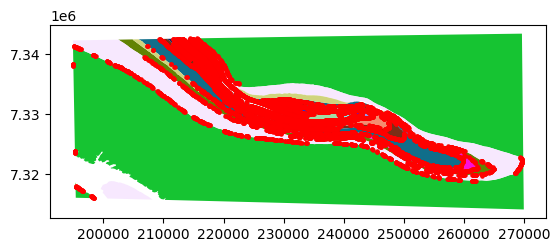

In [ ]:
proj.draw_geology_map(overlay="contacts")

In [ ]:
from loopstructuralvisualisation import Loop3DView
clip_on_dtm=True
if(clip_on_dtm):
    bounding_box = proj.map_data.get_bounding_box()
    model_base = bounding_box['base']
    model_top = bounding_box['top']
    dtm = gdal.Open("../test_data/NTGS_data/Henbury/DEM.tif")
    dtm_val = dtm.GetRasterBand(1).ReadAsArray().T
    geoTrans = dtm.GetGeoTransform()
    minx = geoTrans[0]
    maxx = minx + dtm.RasterXSize * geoTrans[1]
    miny = geoTrans[3]
    maxy = miny + dtm.RasterYSize * geoTrans[5]

    # Convert bounds to gdal raster bounds
    x = np.linspace(minx,maxx,dtm.RasterXSize)
    y = np.linspace(miny,maxy,dtm.RasterYSize)
    dtm_interpolator = RegularGridInterpolator((x,y),dtm_val)
    model.dtm = lambda xyz : dtm_interpolator(xyz[:,:2])

# vtk_path = os.path.join(model_name,'vtk')
# if not os.path.exists(vtk_path):
#     os.mkdir(vtk_path)
# filename = os.path.join(model_name,'vtk','surface_name_{}.vtk')
view = Loop3DView(model)
view.nsteps=np.array([500,500,50])
for sg in model.feature_name_index:
    if( 'super' in sg):
        view.add_data(model.features[model.feature_name_index[sg]])
view.nelements = 3e6
# view.nsteps = np.array([500,500,50])
# view.plot_block_model()
# view.nelements=1e6
view.plot_scalar_field(model.features[-1] , cmap='prism')
# view.plot_model_surfaces(strati=True, )

# if(clip_on_dtm):
#     colours = list(pd.DataFrame(data=proj.stratigraphic_column.column,columns=["name"]).merge(proj.stratigraphic_column.stratigraphicUnits[["name","colour"]], on="name")["colour"])
#     colours.reverse()
    # view.add_dtm(paint_with=lambda xyz: model.evaluate_model(xyz,scale=False), cmap=colours)
# view.add_model()
view.display()

Widget(value='<iframe src="http://localhost:37349/index.html?ui=P_0x7f5bb4c10090_0&reconnect=auto" class="pyvi…

In [ ]:
# proj.map_data.get_map_data(Datatype.FAULT)
proj.deformation_history.get_faults_for_export()

,eventId,name,minAge,maxAge,group,supergroup,avgDisplacement,avgDownthrowDir,influenceDistance,verticalRadius,...,centreX,centreY,centreZ,avgSlipDirX,avgSlipDirY,avgSlipDirZ,avgNormalX,avgNormalY,avgNormalZ,length
0,0,Fault_0,-1.0,-1.0,,,100,NaN,281.407890,1125.631558,...,219678.590616,7.332246e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1139.277277
1,1,Fault_1,-1.0,-1.0,,,100,NaN,328.134653,1312.538611,...,229911.612021,7.327734e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1319.767951
2,10,Fault_10,-1.0,-1.0,,,100,NaN,286.223333,1144.893330,...,219440.876796,7.335317e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1174.209665
3,11,Fault_11,-1.0,-1.0,,,100,NaN,258.193079,1032.772318,...,218405.675438,7.335807e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1036.661022
4,12,Fault_12,-1.0,-1.0,,,100,NaN,466.522295,1866.089182,...,242561.426021,7.329117e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1887.397643
5,13,Fault_13,-1.0,-1.0,,,100,NaN,212.625223,850.500894,...,223297.669902,7.330264e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,856.550825
6,14,Fault_14,-1.0,-1.0,,,100,NaN,473.091821,1892.367283,...,231406.309617,7.330716e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1919.381498
7,15,Fault_15,-1.0,-1.0,,,100,NaN,858.759700,3435.038798,...,218306.729276,7.334200e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3562.272766
9,17,Fault_17,-1.0,-1.0,,,100,NaN,239.049230,956.196920,...,222909.798125,7.331889e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,956.784543
10,18,Fault_18,-1.0,-1.0,,,100,NaN,435.619870,1742.479481,...,222959.200677,7.331526e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1752.582306
